In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import *
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import cv2
import scipy

In [2]:
def alignment_pic(ima1='nutmeg.jpg', ima2='DerekPicture.jpg'):
    """Align two pictures with each other. Image 1 is rotated to be aligned with image 2.
    ima1, ima2: (2D/3D Matrices)
    
    Return 2 2D/3D Matrices of alignment.
    
    
    Note: make sure to toggle `matplotlib.use('TkAgg') or another GUI tool to manually select alignment"""
    from align_image_code import align_images
    
    # high sf
    im2 = plt.imread(ima2)/255.

    # low sf
    im1 = plt.imread(ima1)/255

    # Next align images (this code is provided, but may be improved)
    im1_aligned, im2_aligned = align_images(im1, im2)
    return im1_aligned, im2_aligned

In [3]:
def gaussian_kernel(value, size=False):
    """Calculate the gaussian kernel filter.
    Default is that size = False. That means that the value passed in is a standard deviation.
    If size is True, then that means we pass in a kernel width/height and sigma will be precalculated. Dependencies of this functions are the gaussian blur function.
    Value: (Int) Either standard deviation or desired kernel width/height
    Size: (Bool) True: `value` is kernel width; False: 'Value' is the gaussian sigma
    
    Returns: (2D Matrix) Gaussian Filter """
    if size:
        size = value
        standard_deviation = int(size/6)
        gauss1d = cv2.getGaussianKernel(value, standard_deviation)
        gauss2d = gauss1d @ gauss1d.T
        return gauss2d
    else:
        standard_deviation = value
        size = int(standard_deviation) * 6
        gauss1d = cv2.getGaussianKernel(size, standard_deviation)
        gauss2d = gauss1d @ gauss1d.T
        return gauss2d

In [5]:
def hybrid_images(im1, im2, sigma1, sigma2, debug=False, align=True, reverse_align=False):
    """im1, im2: (2D/3D matrix or filename) Input images (Image 1 is high frequency, Image 2 is low frequency)
    sigma1, sigma2: (int) Standard Deviations to be applied to obtain their gaussian blurs
    debug: debugging mode
    align: (Bool) if alignment is desired
    reverse_align: (Bool) Generally, im1 is aligned to be rotated with im2. If the reverse alignment is desired, please enter True
    
    Returns: (2D/3D matrix) of hybrid image"""
    if reverse_align and align:
        im1, im2 = im2, im1
    
    if align and type(im1) != str:
        import matplotlib
        matplotlib.use('TkAgg')
#         assert im1.shape == im2.shape, "The two matrices are not the same size"
        im1_aligned, im2_aligned = align_images(im1, im2)
    
    if align and type(im1) == str:
        import matplotlib
        matplotlib.use('TkAgg')
        im1_aligned, im2_aligned = alignment_pic(im1, im2)
        
    
    if reverse_align and align:
        im1_aligned, im2_aligned = im2_aligned, im1_aligned
    
    if len(im1_aligned.shape) == 3:
        blur = im1_aligned.copy()
        highfq = im2_aligned.copy()
        for i in range(0,3):
            gauss2d1 = gaussian_kernel(sigma1)
            gauss2d2 = gaussian_kernel(sigma2)
            blur[:,:,i] = convolve2d(im2_aligned[:,:,i], gauss2d1, mode='same')
            highfq[:,:,i] = im1_aligned[:,:,i] - convolve2d(im1_aligned[:,:,i], gauss2d2, mode='same')
        hybrid = np.clip(blur+highfq, a_min=0, a_max=1)
    else:
        gauss2d1 = gaussian_kernel(sigma1)
        gauss2d2 = gaussian_kernel(sigma2)
        blur = convolve2d(np.mean(im2_aligned, axis=2), gauss2d1, mode='same')
        highfq = np.mean(im1_aligned, axis=2) - convolve2d(np.mean(im1_aligned, axis=2), gauss2d2, mode='same')
        hybrid = np.clip(blur+highfq, a_min=0, a_max=1)
    if debug:
        %matplotlib inline
        skio.imshow(hybrid)
    return hybrid
    

Please select 2 points in each image for alignment.


/Users/kevinmiao/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


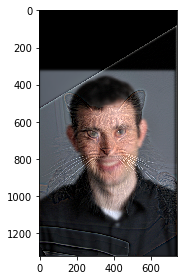

In [6]:
catman = hybrid_images('nutmeg.jpg', 'DerekPicture.jpg', 6,6, debug=True)

In [7]:
skio.imsave("catman.jpg", catman)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
